In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
folder_path = '/content/drive/MyDrive/EU_Green/Catalonia'
os.chdir(folder_path)


Mounted at /content/drive


In [ ]:
!pip install catboost

In [ ]:
import os
import pickle
import requests
from zipfile import ZipFile
from tqdm import tqdm
import warnings
from scipy.stats import mstats
from scipy import stats
warnings.filterwarnings("ignore")
import json
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import gc
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
df = pd.read_csv('small_model_prepared.csv')

In [ ]:
scaler = StandardScaler()
normalized_df = pd.DataFrame()
for col in df.columns:
  mean = df[col].mean()
  std_dev = df[col].std()
  if abs(mean) < 1e-6 and abs(std_dev - 1) < 1e-6:
      normalized_df[col] = df[col]
  else:
      df[col] = scaler.fit_transform(df[[col]])
      normalized_df[col] = df[col]

normalized_df.describe()

,pp_total_energy,pp_total_Emissions,heating_efficiency,cooling_efficiency,ac_efficiency,Insulation Performance Index,Energia primària no renovable,Emissions de CO2,Consum d'energia final,Renewable_Energy_Score,...,US_EDIFICI_Terciari,US_EDIFICI_Terciario,US_EDIFICI_Vivienda individual en bloque de viviendas,US_EDIFICI_Vivienda unifamiliar,FR_Encoded_COMARCA,FR_Encoded_Normativa construcció,FR_Encoded_Motiu de la certificacio,FR_Encoded_Eina de certificacio,FR_Encoded_VALOR AILLAMENTS CTE,FR_Encoded_VALOR FINESTRES CTE
count,1.336925e+06,1.336925e+06,1.336925e+06,1.336925e+06,1.336925e+06,1.336925e+06,1.336925e+06,1.336925e+06,1.336925e+06,1336925.0,...,1.336925e+06,1.336925e+06,1.336925e+06,1.336925e+06,1.336925e+06,1.336873e+06,1.336925e+06,1.336871e+06,1.336925e+06,1.336925e+06
mean,1.226114e-17,-2.055747e-17,5.429170e-15,9.358484e-17,-6.599861e-16,-3.638481e-16,-8.509134e-16,-1.537425e-17,2.741297e-16,0.0,...,8.805750e-17,-2.490494e-17,-7.560237e-18,5.054331e-18,-3.095313e-17,-3.163597e-17,2.118036e-16,5.004893e-16,-1.224519e-16,5.503428e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.104304e+00,-3.951677e+00,-8.302567e+00,-5.920042e+00,-8.988971e+00,-7.801966e-01,-1.034906e+00,-3.530821e-01,-1.873308e+00,0.0,...,-2.966380e-01,-1.046285e-01,-2.757726e-01,-1.492923e-01,-1.046858e+00,-1.849752e+00,-1.910828e+00,-4.711195e+00,-1.993673e+00,-2.083148e+00
25%,-5.779959e-01,-5.765473e-01,-3.629532e-01,1.269923e-01,-1.615129e-01,-1.528343e-01,-2.608346e-01,-9.759818e-02,-4.179172e-01,0.0,...,-2.966380e-01,-1.046285e-01,-2.757726e-01,-1.492923e-01,-8.134294e-01,-7.618990e-01,-9.436666e-01,2.164392e-01,-1.534416e+00,-1.537942e+00
50%,-8.311001e-02,-7.119746e-02,-3.617922e-01,1.332904e-01,-1.591337e-01,1.776524e-02,-6.221383e-02,-2.777819e-02,-2.364248e-02,0.0,...,-2.966380e-01,-1.046285e-01,-2.757726e-01,-1.492923e-01,-5.325487e-01,8.639922e-01,7.017102e-01,2.164392e-01,5.893062e-01,5.887377e-01
75%,5.660725e-01,5.784482e-01,2.071183e-01,1.401574e-01,9.034568e-01,1.762252e-01,1.773902e-01,5.717856e-02,3.408991e-01,0.0,...,-2.966380e-01,-1.046285e-01,-2.757726e-01,-1.492923e-01,1.495306e+00,8.639922e-01,7.273981e-01,2.164392e-01,5.893062e-01,5.887377e-01
max,5.892431e+00,5.841913e+00,2.887039e+02,3.423937e+02,1.344246e+01,1.048080e+02,3.862747e+02,4.114838e+02,4.416617e+02,0.0,...,3.371112e+00,9.557626e+00,3.626176e+00,6.698267e+00,1.495306e+00,8.639922e-01,7.273981e-01,2.164392e-01,5.893062e-01,5.887377e-01


### model

In [110]:


def model_pipeline(model_type, df , target, cross_val=False, grid_search=False, transform=False):

  if target not in df.columns:
      raise ValueError("DataFrame must contain a target column as the dependent variable.")
  if transform:
    df[target] = df[target].apply(lambda x: x if x >= 0 else 0)
    original_target = df[target]

    df[target], boxcox_lambda = stats.boxcox(df[target] + 1)
    lower_percentile = np.percentile(df[target], 1)
    upper_percentile = np.percentile(df[target], 99)
    df[target] = np.clip(df[target], lower_percentile, upper_percentile)
    scaler = StandardScaler()
    df[target] = scaler.fit_transform(df[[target]])


  X = df.drop(target, axis=1)
  y = df[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  if transform:
    y_test_original = original_target.loc[y_test.index]
    print('y_test_original', y_test_original.shape )
  else:
    y_test_original = y_test
  X_grid, temp1, y_grid, temp2 = train_test_split(X_train, y_train, test_size=0.8, random_state=42)
  # Define model and parameter grid based on selected model type
  if model_type.lower() == 'random_forest':
      model = RandomForestRegressor(n_estimators=100,
                                    random_state=42,
                                    max_depth=None,
                                    max_features= 0.75,
                                    min_samples_leaf=1,
                                    min_samples_split =4
                                    )
      param_grid = {
          'n_estimators': [100],
          'max_depth': [None,2, 4 ],
          'min_samples_split': [2, 4,],
          'min_samples_leaf': [1, 3,],
          'max_features': ['auto', 'sqrt', 0.5, 0.75, 1.0]
      }
  elif model_type.lower() == 'xgboost':
      model = XGBRegressor(n_estimators=100,
                           random_state=42,
                           use_label_encoder=False,
                           eval_metric='rmse',
                           gamma = 1.0,
                           learning_rate = 0.1,
                           max_depth = 4,
                           subsample = 0.5
                           )
      param_grid = {
          'n_estimators': [100,],
          'max_depth': [2,4],
          'learning_rate': [0.01, 0.1],
          'gamma': [0,  1.0],
          'subsample': [0.5,  1.0],

      }
  elif model_type.lower() == 'catboost':
      model = CatBoostRegressor(iterations=300,
                                random_seed=42,
                                verbose=0,
                                border_count = 64,
                                depth = 5,
                                l2_leaf_reg=0.5,
                                learning_rate=0.1
                                )
      param_grid = {
           'iterations': [100, 300,],
            'depth': [3, 5, ],
            'learning_rate': [0.01, 0.1],
            'l2_leaf_reg': [0, 0.5, 1.0],
            'border_count': [32, 64],
      }
  else:
      raise ValueError("Unsupported model_type. Choose from 'random_forest', 'xgboost', 'catboost'.")

  # If grid_search flag is True, perform grid search hyperparameter tuning using 5-fold CV.
  if grid_search:
      print("Starting grid search for hyperparameter tuning...")
      print('data for grid search: ',X_grid.shape)
      grid = GridSearchCV(estimator=model, param_grid=param_grid,
                          cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
      grid.fit(X_grid, y_grid)
      print("Best parameters from Grid Search:", grid.best_params_)
      best_model = grid.best_estimator_
  else:
      best_model = model

  # If cross_val flag is True, perform 5-fold cross validation on the selected model.
  if cross_val:
      print("Performing 5-fold cross-validation...")
      cv_scores = cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
      print("Cross Validation Scores (neg MSE):", cv_scores)
      print("Mean CV Score (neg MSE):", cv_scores.mean())

  # Train the final model on the full dataset
  print("training the model ...")

  best_model.fit(X_train, y_train)

  print("Model training is complete.")

  # Extract and plot feature importance if available
  if hasattr(best_model, "feature_importances_"):
      importances = best_model.feature_importances_
      imp_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
      imp_df = imp_df.sort_values(by='importance', ascending=False)
      print("Feature Importances:")
      print(imp_df)
      imp_df.plot(kind='bar', x='feature', y='importance', figsize=(8,6),
                  title="Feature Importances")
      plt.ylabel("Importance")
      plt.tight_layout()
      plt.show()
  else:
      print("The selected model does not support a 'feature_importances_' attribute.")
  # ---------------------------- Prediction & Inversion ---------------------------- #
  print('prediction part ...')
  if transform:
    y_pred_scaled = best_model.predict(X_test).reshape(-1, 1)
    y_pred_boxcox = scaler.inverse_transform(y_pred_scaled)
    y_pred_original = inv_boxcox(y_pred_boxcox, boxcox_lambda) - 1
  else:
    y_pred_original = best_model.predict(X_test)

  print("Number of NaN values in predictions before dropping:", np.count_nonzero(np.isnan(y_pred_original)))
  # Create a mask for valid (non-NaN) predictions.
  mask = ~np.isnan(y_pred_original)
  # Apply the mask to both the predictions and the corresponding true target values.
  # If y_test_original is a Pandas Series, this will still work.
  y_pred_clean = y_pred_original[mask]
  mask = ~np.isnan(y_pred_original).flatten()
  y_test_clean = y_test_original[mask]
  print("Number of NaN values in predictions after dropping:", np.count_nonzero(np.isnan(y_pred_clean)))
  print('len test:', len(y_test_clean))
  mse = mean_squared_error(y_test_clean, y_pred_clean)
  mae = mean_absolute_error(y_test_clean, y_pred_clean)
  r2 = r2_score(y_test_clean, y_pred_clean)

  print("Mean Squared Error:", mse)
  print("Mean Absolute Error:", mae)
  print("R² Score:", r2)
  # --------------------------------------------------------------------------------- #
  # Return the fitted (best) model in case further analysis or predictions are needed.
  return best_model , X_test, y_test , y_pred_original



In [ ]:
gc.collect()

14721

### feature selection

In [ ]:
correlations1 = df.corr()["preprocessed_Consum d'energia final" ]
selected_cols = correlations1[abs(correlations1) > 0.4].index.tolist()
data = df[selected_cols]
selected_cols

NameError: name 'df' is not defined

In [ ]:
correlations1 = df.corr()["preprocessed_Consum d'energia final" ]
selected_cols = correlations1[abs(correlations1) > 0.15].index.tolist()
data = df[selected_cols]
selected_cols

['pp_total_energy',
 'pp_total_Emissions',
 'heating_efficiency',
 'Energia primària no renovable',
 "Consum d'energia final",
 "preprocessed_Cost anual aproximat d'energia per habitatge",
 'preprocessed_Energia primària no renovable',
 'preprocessed_Emissions de CO2',
 "preprocessed_Consum d'energia final",
 'preprocessed_VALOR AILLAMENTS',
 'preprocessed_VALOR FINESTRES',
 'preprocessed_Energia calefacció demanda',
 'age',
 'preprocessed_heating_efficiency',
 "ENCODED Qualificació de consum d'energia primaria no renovable",
 "ENCODED Qualificacio d'emissions de CO2",
 'ENCODED Qualificació emissions calefacció',
 'ENCODED Qualificació emissions refrigeració',
 'ENCODED Qualificació emissions ACS',
 'ENCODED Qualificació energia calefacció',
 'ENCODED Qualificació energia refrigeració',
 'ENCODED Qualificació energia ACS',
 'ENCODED Qualificació energia calefacció demanda',
 'ENCODED Qualificació energia refrigeració demanda',
 'VEHICLE ELECTRIC_NO',
 'VEHICLE ELECTRIC_other',
 'XARXA

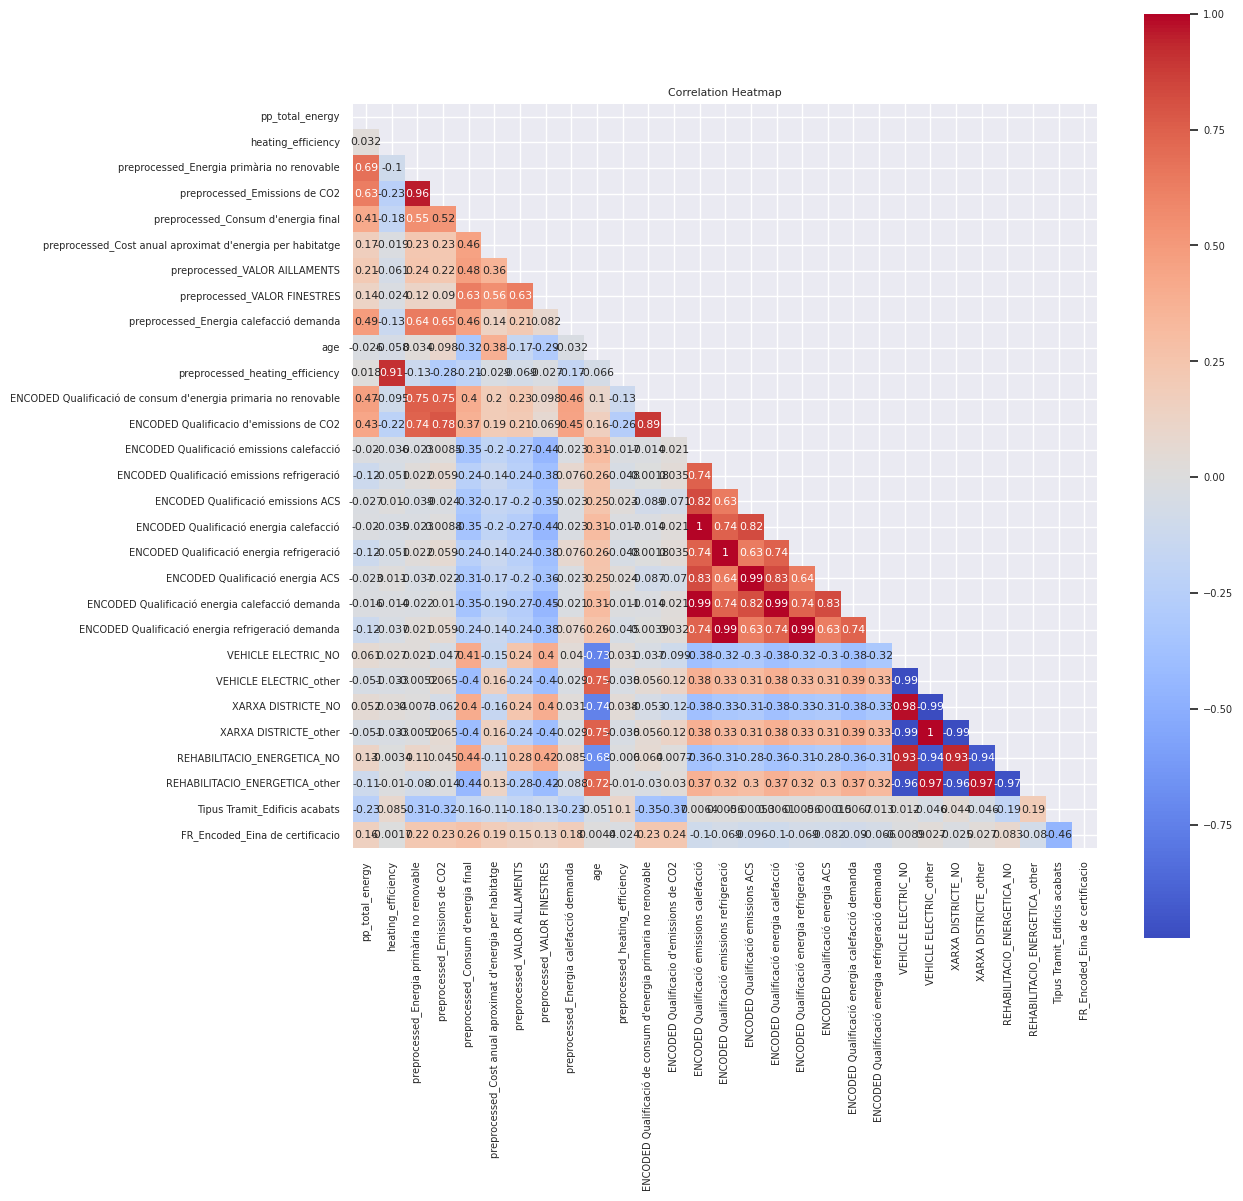

In [ ]:
data = data.drop(columns=['pp_total_Emissions', "preprocessed_Consum d'energia final_per_m2",
 'preprocessed_Emissions de CO2 per m2', "Consum d'energia final_per_m2",
])
corr_matrix1 = data.corr()
matrix = np.triu(corr_matrix1)
plt.figure(figsize=(12, 12))
sns.set(font_scale=.65)
sns.heatmap(corr_matrix1,annot=True, cmap='coolwarm', square=True , mask =matrix )
plt.title("Correlation Heatmap")
plt.show()

In [10]:
selected_cols= ['pp_total_energy',
                'pp_total_Emissions',
                'heating_efficiency',
                'Energia primària no renovable',
                "Consum d'energia final",
                "preprocessed_Cost anual aproximat d'energia per habitatge",
                'preprocessed_Energia primària no renovable',
                'preprocessed_Emissions de CO2',
                "preprocessed_Consum d'energia final",
                'preprocessed_VALOR AILLAMENTS',
                'preprocessed_VALOR FINESTRES',
                'preprocessed_Energia calefacció demanda',
                'age',
                'preprocessed_heating_efficiency',
                "ENCODED Qualificació de consum d'energia primaria no renovable",
                "ENCODED Qualificacio d'emissions de CO2",
                'ENCODED Qualificació emissions calefacció',
                'ENCODED Qualificació emissions refrigeració',
                'ENCODED Qualificació emissions ACS',
                'ENCODED Qualificació energia calefacció',
                'ENCODED Qualificació energia refrigeració',
                'ENCODED Qualificació energia ACS',
                'ENCODED Qualificació energia calefacció demanda',
                'ENCODED Qualificació energia refrigeració demanda',
                'VEHICLE ELECTRIC_NO',
                'VEHICLE ELECTRIC_other',
                'XARXA DISTRICTE_NO',
                'XARXA DISTRICTE_other',
                'REHABILITACIO_ENERGETICA_NO',
                'REHABILITACIO_ENERGETICA_other',
                'Tipus Tramit_Edificis acabats',
                'FR_Encoded_Eina de certificacio']


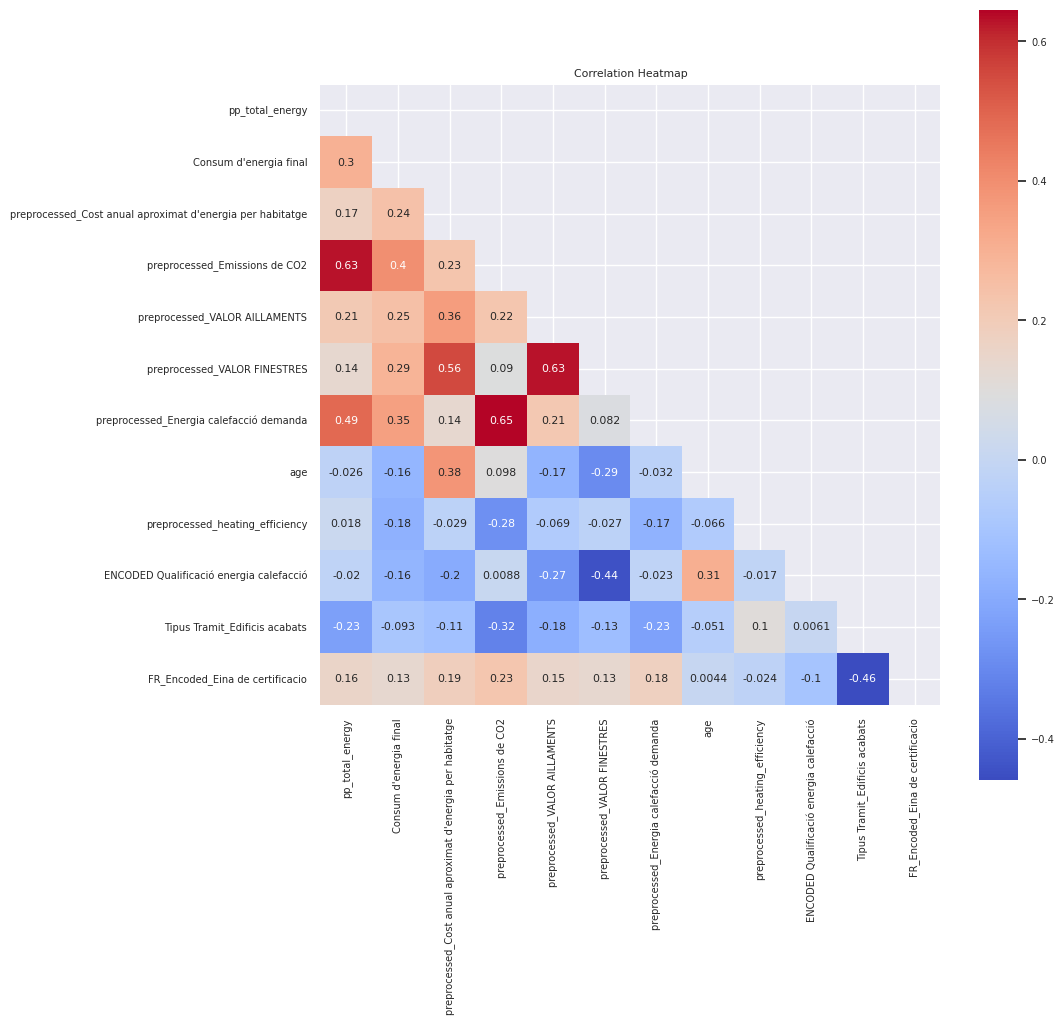

In [11]:
data = df[selected_cols]

data = data.drop(columns=[
                          'pp_total_Emissions',
                          "preprocessed_Consum d'energia final",
                          "ENCODED Qualificació de consum d'energia primaria no renovable" ,
                          'preprocessed_Energia primària no renovable',
                          "ENCODED Qualificacio d'emissions de CO2",
                          'ENCODED Qualificació emissions calefacció',
                          'ENCODED Qualificació emissions refrigeració',
                          'ENCODED Qualificació emissions ACS',
                          # 'ENCODED Qualificació energia calefacció',
                          'ENCODED Qualificació energia refrigeració',
                          'ENCODED Qualificació energia ACS',
                          'ENCODED Qualificació energia calefacció demanda',
                          'ENCODED Qualificació energia refrigeració demanda',
                           'heating_efficiency',
                          'VEHICLE ELECTRIC_other',
                           'VEHICLE ELECTRIC_NO',
                          'XARXA DISTRICTE_NO',
                          'XARXA DISTRICTE_other',
                          'REHABILITACIO_ENERGETICA_NO',
                          'REHABILITACIO_ENERGETICA_other',
                           'Energia primària no renovable',
                            # 'Emissions de CO2',
                            # "Consum d'energia final",


])
corr_matrix = data.corr()
matrix = np.triu(corr_matrix)
plt.figure(figsize=(10, 10))
sns.set(font_scale=.65)
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', square=True, mask=matrix)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
data.columns.tolist()

['pp_total_energy',
 "Consum d'energia final",
 "preprocessed_Cost anual aproximat d'energia per habitatge",
 'preprocessed_Emissions de CO2',
 'preprocessed_VALOR AILLAMENTS',
 'preprocessed_VALOR FINESTRES',
 'preprocessed_Energia calefacció demanda',
 'age',
 'preprocessed_heating_efficiency',
 'ENCODED Qualificació energia calefacció',
 'Tipus Tramit_Edificis acabats',
 'FR_Encoded_Eina de certificacio']

### Random Forest
best params Consum_d'energia_final : 'max_depth': None, 'max_features': 0.75, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100



y_test_original (267385,)
training the model ...
Model training is complete.
Feature Importances:
                                              feature  importance
2                       preprocessed_Emissions de CO2    0.507136
1   preprocessed_Cost anual aproximat d'energia pe...    0.185762
6                                                 age    0.093733
5             preprocessed_Energia calefacció demanda    0.089349
7                     preprocessed_heating_efficiency    0.066345
4                        preprocessed_VALOR FINESTRES    0.017823
0                                     pp_total_energy    0.017226
3                       preprocessed_VALOR AILLAMENTS    0.013856
8             ENCODED Qualificació energia calefacció    0.006195
10                    FR_Encoded_Eina de certificacio    0.002518
9                       Tipus Tramit_Edificis acabats    0.000054


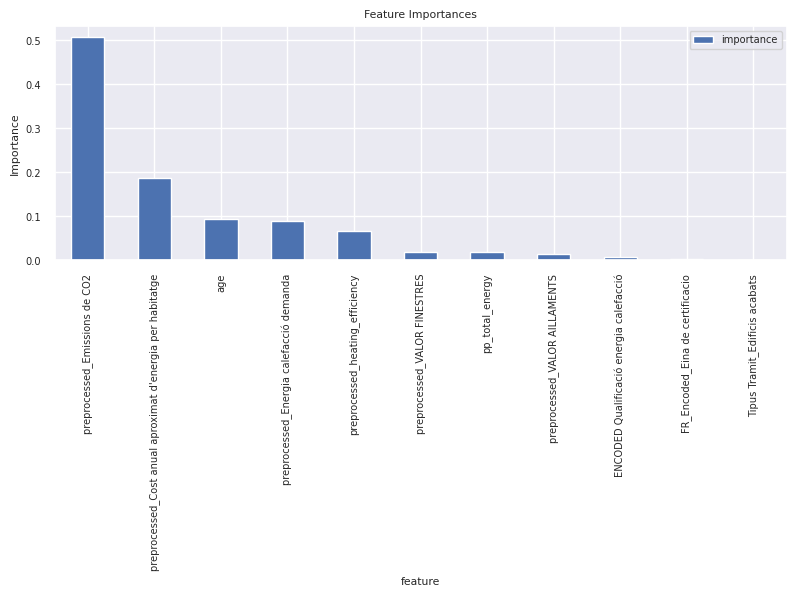

prediction part ...
Number of NaN values in predictions before dropping: 0
Number of NaN values in predictions after dropping: 0
len test: 267385
Mean Squared Error: 0.04021120738841539
Mean Absolute Error: 0.062133342851221254
R² Score: 0.900514761137778


In [14]:
rf_model, X_test, y_test = model_pipeline(model_type="random_forest",
                                            df=data,
                                            cross_val=False,
                                            grid_search=False,
                                            transform=True,
                                            target ="Consum d'energia final" )

### Catboost
{'border_count': 64, 'depth': 5, 'iterations': 300, 'l2_leaf_reg': 0.5, 'learning_rate': 0.1}

y_test_original (267385,)
training the model ...
Model training is complete.
Feature Importances:
                                              feature  importance
2                       preprocessed_Emissions de CO2   49.313528
1   preprocessed_Cost anual aproximat d'energia pe...   23.614734
6                                                 age   13.553484
7                     preprocessed_heating_efficiency    9.178378
5             preprocessed_Energia calefacció demanda    2.406532
8             ENCODED Qualificació energia calefacció    0.677976
0                                     pp_total_energy    0.603212
4                        preprocessed_VALOR FINESTRES    0.248432
10                    FR_Encoded_Eina de certificacio    0.231525
3                       preprocessed_VALOR AILLAMENTS    0.171079
9                       Tipus Tramit_Edificis acabats    0.001120


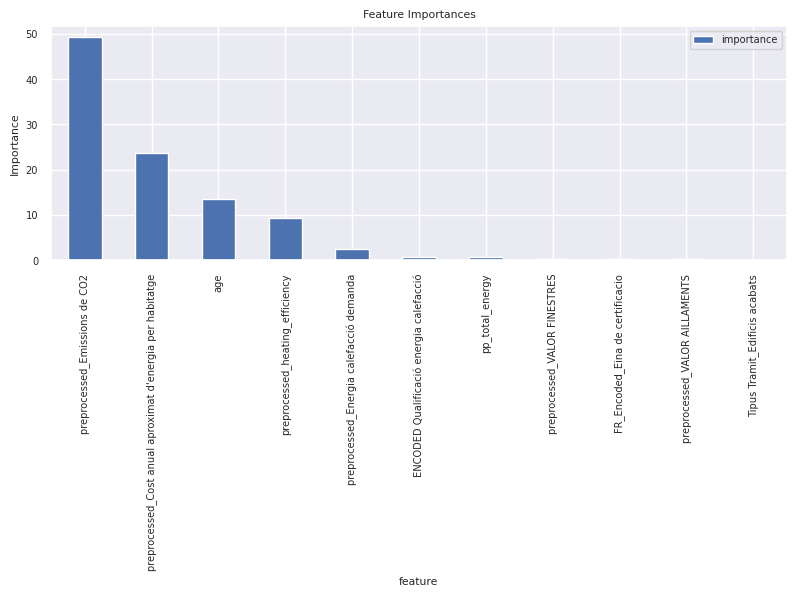

prediction part ...
Number of NaN values in predictions before dropping: 26
Number of NaN values in predictions after dropping: 0
len test: 267359
Mean Squared Error: 0.08352805863993358
Mean Absolute Error: 0.12680753044910797
R² Score: 0.788159010068296


In [111]:
data = data.fillna(data.median())
catboost_model, X_test, y_test , y_pred = model_pipeline(model_type="catboost",
                                            df=data,
                                            cross_val=False,
                                            grid_search=False,
                                            transform=True,
                                            target ="Consum d'energia final" )

### XGBoost
{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.5}

y_test_original (267385,)
training the model ...
Model training is complete.
Feature Importances:
                                              feature  importance
2                       preprocessed_Emissions de CO2    0.534657
6                                                 age    0.180400
1   preprocessed_Cost anual aproximat d'energia pe...    0.095540
7                     preprocessed_heating_efficiency    0.078139
5             preprocessed_Energia calefacció demanda    0.034435
8             ENCODED Qualificació energia calefacció    0.026725
0                                     pp_total_energy    0.024254
10                    FR_Encoded_Eina de certificacio    0.012589
4                        preprocessed_VALOR FINESTRES    0.007998
3                       preprocessed_VALOR AILLAMENTS    0.003425
9                       Tipus Tramit_Edificis acabats    0.001837


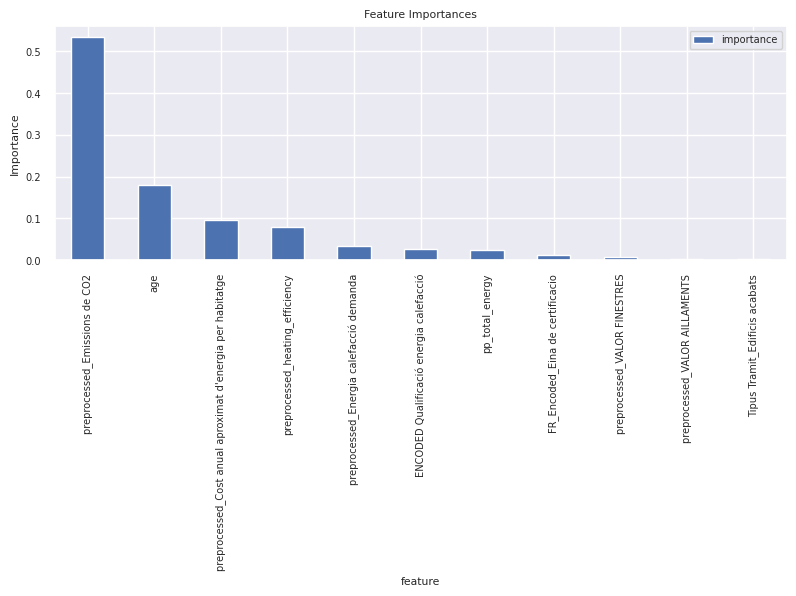

prediction part ...
Number of NaN values in predictions before dropping: 0
Number of NaN values in predictions after dropping: 0
len test: 267385
Mean Squared Error: 0.08141687404410262
Mean Absolute Error: 0.13621389638106982
R² Score: 0.7934258785705255


In [128]:
data = data.fillna(data.median())
xgb_model,X_test, y_test , y_pred_org = model_pipeline(model_type="xgboost",
                                            df=data,
                                            cross_val=False,
                                            grid_search=False,
                                            transform=True,
                                            target ="Consum d'energia final" )

y_test_original (267385,)
training the model ...
Model training is complete.
Feature Importances:
                                              feature  importance
2                       preprocessed_Emissions de CO2    0.491744
6                                                 age    0.201273
1   preprocessed_Cost anual aproximat d'energia pe...    0.107638
7                     preprocessed_heating_efficiency    0.078479
5             preprocessed_Energia calefacció demanda    0.038488
8             ENCODED Qualificació energia calefacció    0.034609
0                                     pp_total_energy    0.014109
10                    FR_Encoded_Eina de certificacio    0.013472
4                        preprocessed_VALOR FINESTRES    0.010293
3                       preprocessed_VALOR AILLAMENTS    0.007492
9                       Tipus Tramit_Edificis acabats    0.002403


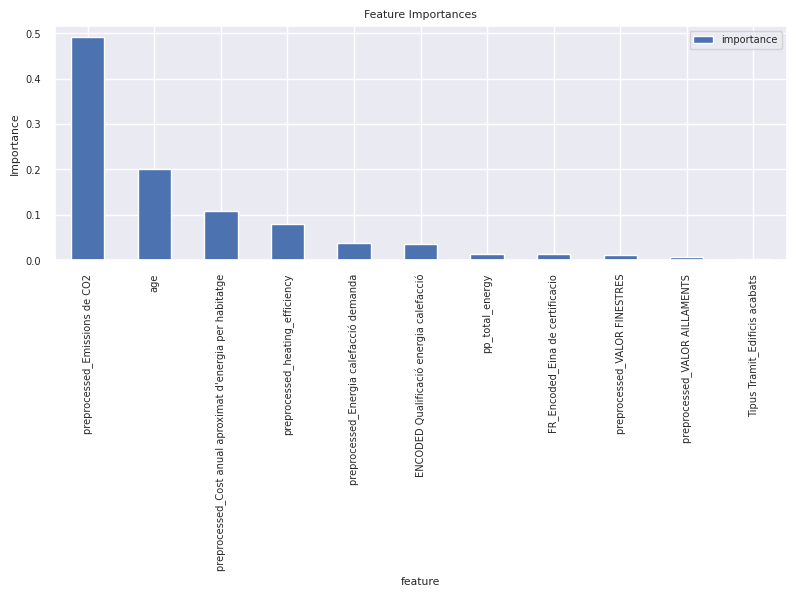

prediction part ...
Number of NaN values in predictions before dropping: 18
Number of NaN values in predictions after dropping: 0
len test: 267367
Mean Squared Error: 0.07758675757851954
Mean Absolute Error: 0.12154884314074468
R² Score: 0.8137848993891642


In [13]:
data = data.fillna(data.median())
xgb_model, X_test, y_test = model_pipeline(model_type="xgboost",
                                            df=data,
                                            cross_val=False,
                                            grid_search=False,
                                            transform=True,
                                            target ="Consum d'energia final" )

### Ensemble

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
import numpy as np

target ="Consum d'energia final"
# ------------------transformation ------------------
data[target] = data[target].apply(lambda x: x if x >= 0 else 0)
original_target = data[target]

data[target], boxcox_lambda = stats.boxcox(data[target] + 1)
lower_percentile = np.percentile(data[target], 1)
upper_percentile = np.percentile(data[target], 99)
data[target] = np.clip(data[target], lower_percentile, upper_percentile)
scaler = StandardScaler()
data[target] = scaler.fit_transform(data[[target]])

# --------------------test train split ----------------------
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test_original = original_target.loc[y_test.index]
print('y_test_original', y_test_original.shape )

# ---------------------- meta-regressor ---------------------
# (a simple and interpretable model is often chosen)
meta_reg = LinearRegression()

# Create a list of base estimators for stacking
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('catboost', catboost_model)
]


# Build the Stacking Regressor
stacking_ensemble = StackingRegressor(estimators=estimators, final_estimator=meta_reg)

# Train the stacking ensemble
stacking_ensemble.fit(X_train, y_train)

# Predict on test data
ensemble_predictions = stacking_ensemble.predict(X_test)

# -------------Inversion -----------------------
y_pred_scaled = ensemble_predictions.reshape(-1, 1)
y_pred_boxcox = scaler.inverse_transform(y_pred_scaled)
y_pred_original = inv_boxcox(y_pred_boxcox, boxcox_lambda) - 1

mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R² Score:", r2)

stacking_ensemble

y_test_original (267385,)
Mean Squared Error: 0.04083343863681367
Mean Absolute Error: 0.06565375904333184
R² Score: 0.8976289933862698


StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_features=0.75,
                                                     min_samples_split=4,
                                                     random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='rmse',
                                            feature_types=None, gam...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x7a42d771bc50>)],
                  final_estimator=LinearRegression())

### Shap and Lime

In [ ]:
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

fig = shap.summary_plot(shap_values, X_test, show=False)
plt.gcf().set_size_inches(12, 8)
plt.rcParams.update({'font.size': 10})
plt.tight_layout()
plt.show()

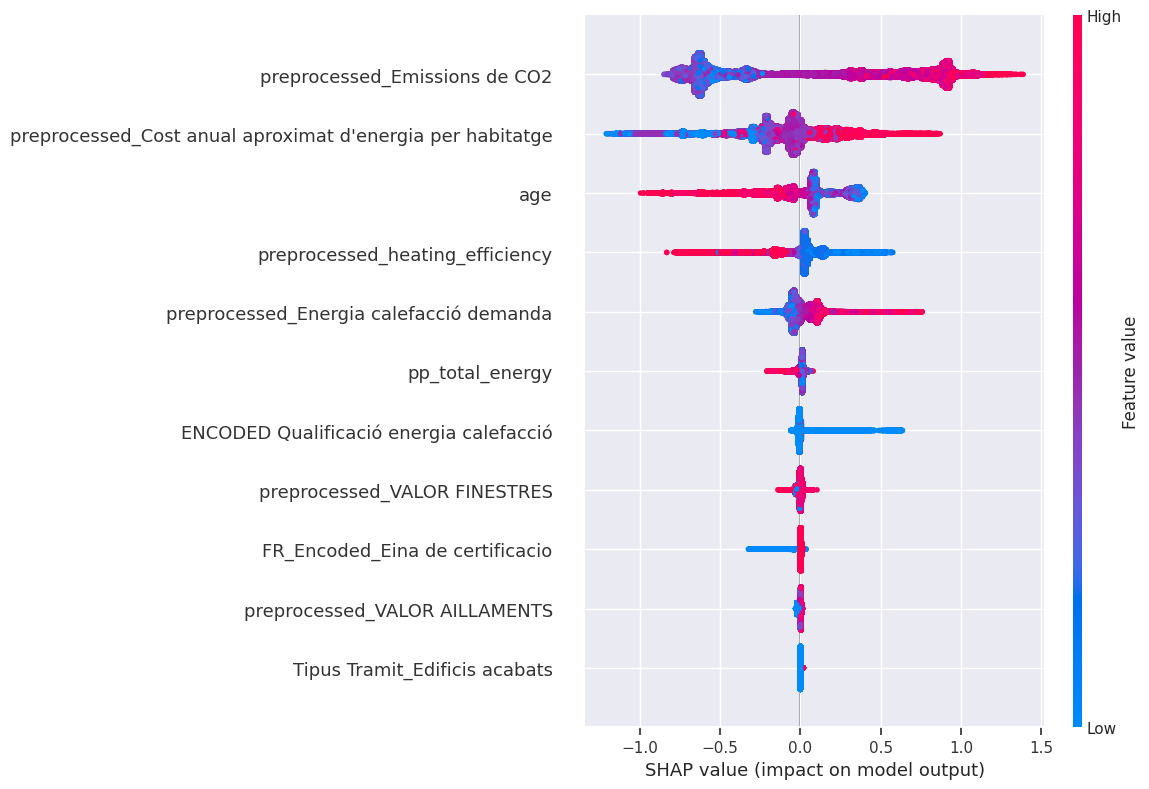

In [ ]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

fig = shap.summary_plot(shap_values, X_test, show=False)
plt.gcf().set_size_inches(12, 8)
plt.rcParams.update({'font.size': 10})
plt.tight_layout()
plt.show()

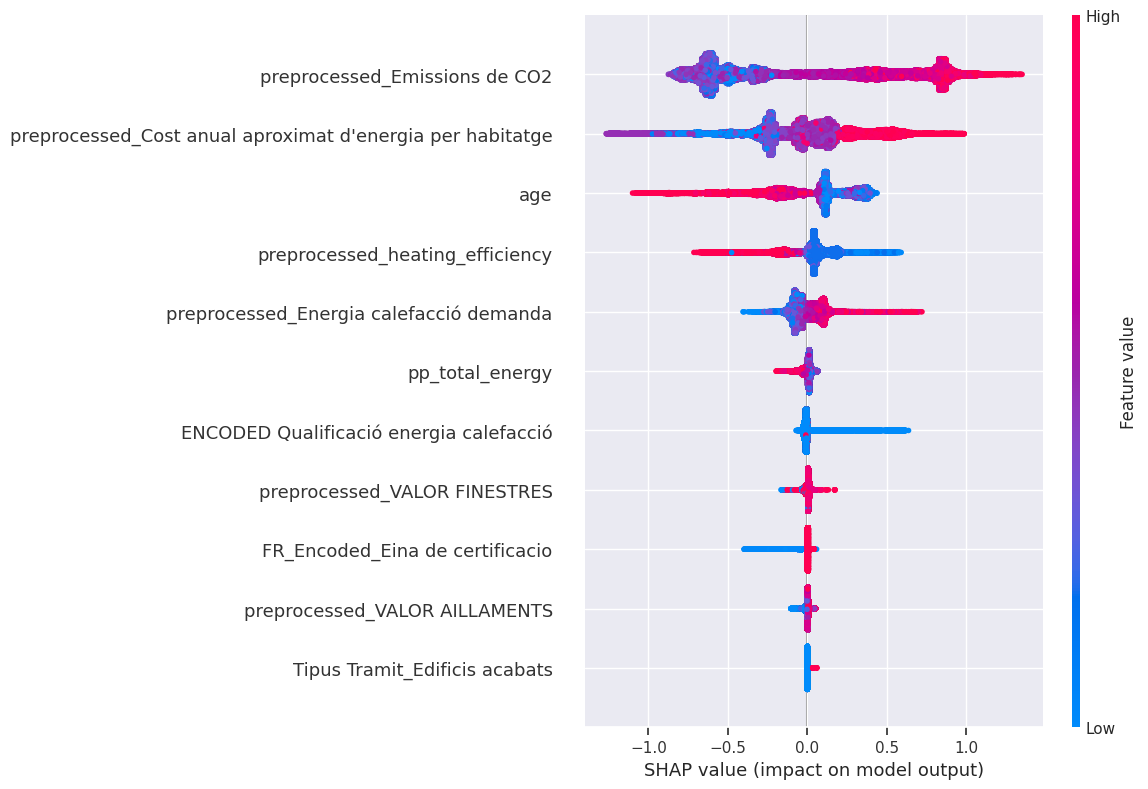

In [ ]:
import shap

explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)

fig = shap.summary_plot(shap_values, X_test, show=False)
plt.gcf().set_size_inches(12, 8)
plt.rcParams.update({'font.size': 10})
plt.tight_layout()
plt.show()

Missing values in X_train: 0


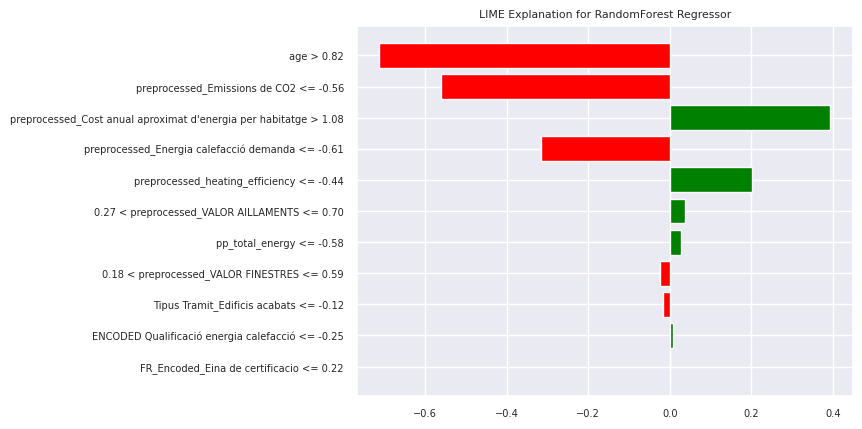

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from catboost import CatBoostRegressor
import lime.lime_tabular

# Assuming 'data' is your DataFrame
target ="Consum d'energia final"
X = data.drop(target, axis=1)
y = data[target]

# Check for missing values
print("Missing values in X_train:", X.isnull().sum().sum())

# Ensure no missing values
X.fillna(X.median(), inplace=True)  # Replace missing values with mean

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LIME explainer for regression tasks
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    mode='regression',
    feature_names=X_train.columns,
    discretize_continuous=True,
    random_state=42
)

# Choose an instance to explain from the test set
instance = X_test.head(1)

# Explain the XGBoost Regressor prediction
explanation_xgb = explainer.explain_instance(
    data_row=instance.values[0],  # Pass a single row (1D array)
    predict_fn=lambda x: rf_model.predict(x),  # Use a lambda function for predict
    num_features=len(X_train.columns),
)

# Visualize the explanation for XGBoost
fig_xgb = explanation_xgb.as_pyplot_figure()
plt.title("LIME Explanation for RandomForest Regressor")
plt.show()


Missing values in X_train: 0


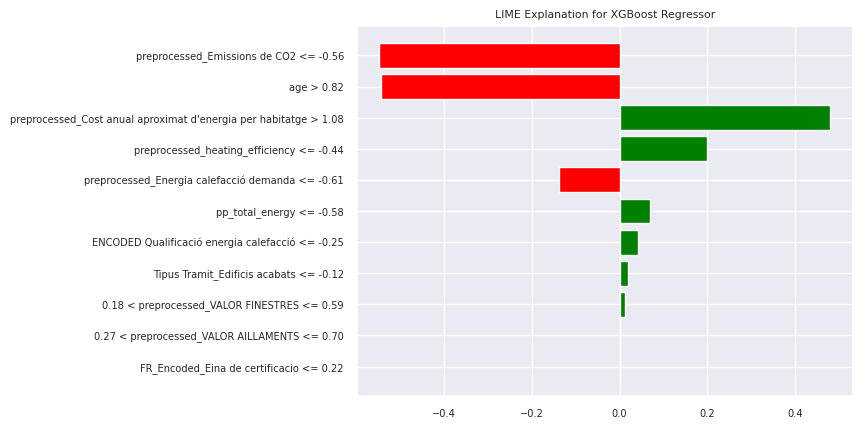

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from catboost import CatBoostRegressor
import lime.lime_tabular

# Assuming 'data' is your DataFrame
target ="Consum d'energia final"
X = data.drop(target, axis=1)
y = data[target]

# Check for missing values
print("Missing values in X_train:", X.isnull().sum().sum())

# Ensure no missing values
X.fillna(X.median(), inplace=True)  # Replace missing values with mean

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LIME explainer for regression tasks
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    mode='regression',
    feature_names=X_train.columns,
    discretize_continuous=True,
    random_state=42
)

# Choose an instance to explain from the test set
instance = X_test.head(1)

# Explain the XGBoost Regressor prediction
explanation_xgb = explainer.explain_instance(
    data_row=instance.values[0],  # Pass a single row (1D array)
    predict_fn=lambda x: xgb_model.predict(x),  # Use a lambda function for predict
    num_features=len(X_train.columns),
)

# Visualize the explanation for XGBoost
fig_xgb = explanation_xgb.as_pyplot_figure()
plt.title("LIME Explanation for XGBoost Regressor")
plt.show()


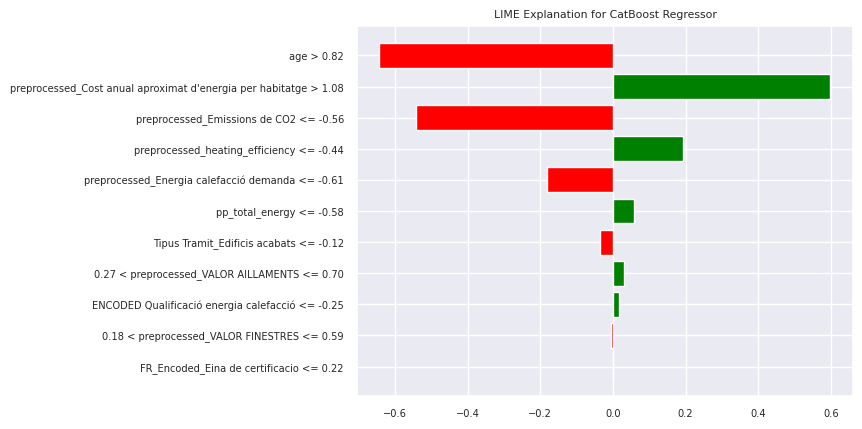

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from catboost import CatBoostRegressor
import lime.lime_tabular

# Assuming 'data' is your DataFrame
target ="Consum d'energia final"
X = data.drop(target, axis=1)
y = data[target]

# Ensure no missing values
X.fillna(X.median(), inplace=True)  # Replace missing values with mean

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LIME explainer for regression tasks
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    mode='regression',
    feature_names=X_train.columns,
    discretize_continuous=True,
    random_state=42
)

# Choose an instance to explain from the test set
instance = X_test.head(1)

# Explain the XGBoost Regressor prediction
explanation_xgb = explainer.explain_instance(
    data_row=instance.values[0],  # Pass a single row (1D array)
    predict_fn=lambda x: catboost_model.predict(x),  # Use a lambda function for predict
    num_features=len(X_train.columns),
)

# Visualize the explanation for XGBoost
fig_xgb = explanation_xgb.as_pyplot_figure()
plt.title("LIME Explanation for CatBoost Regressor")
plt.show()


### Bonus

In [150]:
sample =pd.DataFrame()

In [151]:
sample["Tipus Tramit"] = 'Edificis acabats'
sample["Emissions de CO2	"] = 35
sample["age"] = 3
sample["VALOR FINESTRES"] = 4
sample["Energia calefacció"] = 54
sample["Energia refrigeració"] = 16
sample["Emissions calefacció"] = 10
sample["DATA_ENTRADA"] = '29/01/2022 '
sample["VALOR AILLAMENTS	"] = 0.8
sample['Qualificació energia calefacció'] = 'D'
sample

,758216
Cost anual aproximat d'energia per habitatge,16.75
Emissions de CO2,34.96
VALOR AILLAMENTS,0.73
VALOR FINESTRES,4
Energia calefacció demanda,36.48
Qualificació energia calefacció,D
Tipus Tramit,Edificis acabats
Eina de certificacio,CE3X
DATA_ENTRADA,29/01/2022
Energia calefacció,54


In [57]:

label_mapping = {'A': 0, 'B': 1, 'C': 2 , 'D': 3, 'E':4, 'F':5, 'G':6, '-':99999, 'other':99999}
sample["ENCODED Qualificació energia calefacció"] = 3

'Eina de certificacio' 'CYPE'

age= 5

Tipus Tramit = Edificis existents

emission de co2 = 34.96
DATA_ENTRADA	29/01/2023

cooling energy	15.18
heating energy 58

In [59]:
sample ['Tipus Tramit_Edificis acabats'] = 0

In [61]:
sample

,758216
Cost anual aproximat d'energia per habitatge,16.75
Emissions de CO2,34.96
VALOR AILLAMENTS,0.73
VALOR FINESTRES,3.78
Energia calefacció demanda,36.48
Qualificació energia calefacció,D
Tipus Tramit,Edificis existents
Eina de certificacio,CYPE
DATA_ENTRADA,13/03/2023
Energia calefacció,53.39


In [82]:
sample["preprocessed_Cost anual aproximat d'energia per habitatge"] = -0.225630
sample["preprocessed_Emissions de CO2"] = 0.215355
sample["preprocessed_VALOR AILLAMENTS"] = data["preprocessed_VALOR AILLAMENTS"].median()
sample["preprocessed_VALOR FINESTRES"] = data["preprocessed_VALOR FINESTRES"].median()
sample["preprocessed_heating_efficiency"] = 1.846062
sample["pp_total_energy"] = data["pp_total_energy"].median()
sample["preprocessed_Energia calefacció demanda"] = -1.547148
sample ['ENCODED Qualificació energia calefacció'] =-0.249285
sample['FR_Encoded_Eina de certificacio'] = data['FR_Encoded_Eina de certificacio'].median()

In [85]:
features = ['pp_total_energy',
       "preprocessed_Cost anual aproximat d'energia per habitatge",
       'preprocessed_Emissions de CO2', 'preprocessed_VALOR AILLAMENTS',
       'preprocessed_VALOR FINESTRES',
       'preprocessed_Energia calefacció demanda', 'age',
       'preprocessed_heating_efficiency',
       'ENCODED Qualificació energia calefacció',
       'Tipus Tramit_Edificis acabats', 'FR_Encoded_Eina de certificacio']
sample[features]

,758216
pp_total_energy,-0.08311
preprocessed_Cost anual aproximat d'energia per habitatge,-0.22563
preprocessed_Emissions de CO2,0.215355
preprocessed_VALOR AILLAMENTS,0.273779
preprocessed_VALOR FINESTRES,0.178779
preprocessed_Energia calefacció demanda,-1.547148
age,0.817
preprocessed_heating_efficiency,1.846062
ENCODED Qualificació energia calefacció,-0.249285
Tipus Tramit_Edificis acabats,0


In [90]:
sample[features]

,758216
pp_total_energy,-0.08311
preprocessed_Cost anual aproximat d'energia per habitatge,-0.22563
preprocessed_Emissions de CO2,0.215355
preprocessed_VALOR AILLAMENTS,0.273779
preprocessed_VALOR FINESTRES,0.178779
preprocessed_Energia calefacció demanda,-1.547148
age,0.817
preprocessed_heating_efficiency,1.846062
ENCODED Qualificació energia calefacció,-0.249285
Tipus Tramit_Edificis acabats,0


In [134]:
y_pred =rf_model.predict(np.array(sample[features]).reshape(1, -1))
y_pred_boxcox = scaler.inverse_transform(y_pred.reshape(1, -1))
y_pred_original = inv_boxcox(y_pred_boxcox, boxcox_lambda) - 1
y_pred_original

array([[0.0813596]])

In [135]:
y_pred =xgb_model.predict(np.array(sample[features]).reshape(1, -1))
y_pred_boxcox = scaler.inverse_transform(y_pred.reshape(1, -1))
y_pred_original = inv_boxcox(y_pred_boxcox, boxcox_lambda) - 1
y_pred_original

array([[-0.03504699]], dtype=float32)

In [156]:
y_pred =catboost_model.predict(np.array(sample[features]).reshape(1, -1))
y_pred_boxcox = scaler.inverse_transform(y_pred.reshape(1, -1))
y_pred_original = inv_boxcox(y_pred_boxcox, boxcox_lambda) - 1
y_pred_original

array([[-0.09329844]])